In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import glob 

path = 'data/PRSA_Data_20130301-20170228/'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = [pd.read_csv(file) for file in csv_files]

In [3]:
def pre_process(df):
    df['date_time']=pd.to_datetime(df[['year', 'month', 'day','hour']])
    df.drop(columns=['year', 'month', 'day','hour','No'],inplace=True)
    df.set_index('date_time',inplace=True)
    return df

In [4]:
df_preprocessed=[pre_process(df) for df in df_list]

In [5]:
df_group=pd.concat(df_preprocessed)

In [6]:
df_group

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
date_time,,,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan
2013-03-01 01:00:00,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan
2013-03-01 02:00:00,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan
2013-03-01 03:00:00,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan
2013-03-01 04:00:00,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,14.0,58.0,4.0,19.0,500.0,56.0,12.8,1009.9,-17.0,0.0,NNW,3.1,Gucheng
2017-02-28 20:00:00,27.0,83.0,6.0,60.0,700.0,26.0,11.1,1010.4,-15.5,0.0,NW,1.9,Gucheng
2017-02-28 21:00:00,22.0,37.0,7.0,52.0,600.0,27.0,10.5,1010.8,-15.9,0.0,N,2.3,Gucheng


In [7]:
df_group.columns

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

In [9]:

import math
import datetime
import numpy as np 
 


def train_test_split(data,split_fraction,feature_keys):
    data=data[feature_keys]
    train_split = int(split_fraction * int(data.shape[0]))
    data=data._get_numeric_data()
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    data = (data - data_mean) / data_std
    train_data = data.iloc[0 : train_split - 1]
    val_data = data.iloc[train_split:]
    return train_data,val_data

def train_test_split_cyclical_only(data,split_fraction,feature_keys):
    data=data[feature_keys]
    wind_direction={'NNW': 337.5, 'N': 0, 'NW': 315.0, 'NNE': 22.5, 'ENE': 67.5, 'E': 90, 'NE': 45.0, 'W': 270, 'SSW': 202.5, 'WSW': 247.5, 'SE': 135.0, 'WNW': 292.5, 'SSE': 157.5, 'ESE': 112.5, 'S': 180, 'SW': 225.0}
    wdn={i:(wind_direction[i]-min(wind_direction.values()))/(max(wind_direction.values())-min(wind_direction.values())) for i in wind_direction}
    day=24*60*60
    timestamp_s=pd.to_datetime(data.index).map(datetime.datetime.timestamp)
    data['day_sin']=(np.sin(timestamp_s* (2*np.pi/day))).values
    data['day_cos']=(np.cos(timestamp_s* (2*np.pi/day))).values
    data['wd_sin']=data['wd'].map(wind_direction).map(np.sin)
    data['wd_cos']=data['wd'].map(wind_direction).map(np.cos)
    data=data._get_numeric_data()
    train_split = int(split_fraction * int(data.shape[0]))
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    data = (data - data_mean) / data_std
    train_data = data.iloc[0 : train_split - 1]
    val_data = data.iloc[train_split:]
    return train_data,val_data

def create_batch(data,lag,future):
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=data[future+lag-1:].values
    return X,y

def create_batch_multistep(df,lag,future,feature=None):
    if feature is None:
        data=df
    else:
        data=df[feature]
    data.fillna(0.0,inplace=True)
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    df_future=pd.concat([data[lag-1:].shift(-i) for i in range(1,future+1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=df_future.values
    return X,y

In [10]:
future=6
past=6

In [11]:
import numpy as np 

split_fraction = 0.8
feature_keys = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd','WSPM']
X_train_datasets=list()
y_train_datasets=list()
X_test_datasets=list()
y_test_datasets=list()

dataset_names=list()
for item_id, gdf in df_group.groupby('station'):
    gdf.fillna(method='ffill',inplace=True)
    train,test=train_test_split_cyclical_only(gdf,split_fraction,feature_keys)
    train_multi_feature=list()
    test_multi_feature=list()
    for feature in train.columns:
        X_train,y_train=create_batch_multistep(train,past,future,feature)
        X_test,y_test=create_batch_multistep(test,past,future,feature)
        train_multi_feature.append(X_train)
        test_multi_feature.append(X_test)
        if feature=='PM2.5':
            y_train_datasets.append(y_train)
            y_test_datasets.append(y_test)
    X_train_datasets.append(np.stack(train_multi_feature,axis=-1))
    X_test_datasets.append(np.stack(test_multi_feature,axis=-1))
    dataset_names.append(item_id)
X_train_datasets=np.stack(X_train_datasets,axis=0)
y_train_datasets=np.stack(y_train_datasets,axis=0)
X_test_datasets=np.stack(X_test_datasets,axis=0)
y_test_datasets=np.stack(y_test_datasets,axis=0)

In [12]:
X_train_datasets.shape[-1]

15

In [13]:
import jax 
import jax.numpy as jnp 

def get_dataloader(X,y,batch_size,key,axis=0):
    num_train=X.shape[axis]
    indices = jnp.array(list(range(0,num_train)))
    indices=jax.random.permutation(key,indices)
    for i in range(0, len(indices),batch_size):
        batch_indices = jnp.array(indices[i: i+batch_size])
        yield X[:,batch_indices,:,:], y[:,batch_indices]

In [33]:
import optax
from flax import linen as nn
from functools import partial
import distrax

class LSTM(nn.Module):

    @nn.remat    
    @nn.compact   
    def __call__(self, X_batch):
        carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(X_batch)
        #carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(x)
        x=nn.elu(x)
        x=nn.Dense(future)(x)
        return x[:,-1,:]
    

def reparameterize(params):
    mu = params['mu']
    sigma = jax.tree_map(lambda p : jnp.exp(0.5*p),params['log_std'])
    eps = params['eps']
    #eps=jax.tree_map(lambda p: jax.random.normal(key=jax.random.PRNGKey(np.random.randint(42)),shape=p.shape), params['eps'])
    model_params = jax.tree_map(lambda m,e,s : m+e*s,mu,eps,sigma)
    return model_params

def log_likelihood(params, x, y):
    model_params=reparameterize(params)
    preds = jax.vmap(model.apply, (0, 0))(model_params, jnp.array(x))
    return -1.0*jnp.mean(distrax.Normal(preds, 1.0).log_prob(y).sum(axis=-1))
    #return jnp.mean(optax.l2_loss(y,preds).sum(axis=1))

def log_prior(params):
    def flatten(params):
        squared=jax.tree_map(lambda p: distrax.Normal(0.0,20.0).log_prob(p).sum(), params)
        flattten_squared=jnp.sum(jnp.stack(jax.tree_util.tree_leaves(squared['params'])))
        return flattten_squared
    squared_mu=flatten(params['mu'])
    squared_noise=flatten(params['eps'])
    squared_std=flatten(params['log_std'])
    return squared_std+squared_noise+squared_mu

def log_post(params,batch,labels):
    n_data=batch.shape[0]
    return -1./n_data*log_prior(params) + log_likelihood(params,batch,labels)

grad_log_post=jax.jit(jax.grad(log_post))

In [34]:
@partial(jax.jit, static_argnums=(3,4))
def sgld_kernel_momemtum(key, params, momemtum,grad_log_post, dt, X, y_data):
    gamma,eps=0.9,1e-6
    key, subkey = jax.random.split(key, 2)
    grads = grad_log_post(params, X, y_data)
    squared_grads=jax.tree_map(lambda g: jnp.square(g),grads)
    momemtum=jax.tree_map(lambda m,s : gamma*m+(1-gamma)*s,momemtum,squared_grads)
    noise=jax.tree_map(lambda p: jax.random.normal(key=subkey,shape=p.shape), params)
    params=jax.tree_map(lambda p, g,m,n: p-0.5*dt*g/(m+eps)+jnp.sqrt(dt)*n, params, grads,momemtum,noise)
    return key, params,momemtum

def sgld(key,log_post, grad_log_post, num_samples,
                             dt, x_0,X_train_datasets,y_train_datasets,batch_size,
                             test_data=None):
    samples = list()
    loss=list()
    param = x_0
    key_data, key_model = jax.random.split(key, 2)
    momemtum=jax.tree_map(lambda p:jnp.zeros_like(p),param)
    key_data_batch=jax.random.split(key_data, num_samples)
    for i in range(num_samples):
        train_data=get_dataloader(X_train_datasets,y_train_datasets,batch_size,key_data_batch[i],axis=1)
        for _,(X_batch, y_batch) in enumerate(train_data):
            key_model,param,momemtum = sgld_kernel_momemtum(key_model, param,momemtum, grad_log_post, dt, X_batch, y_batch)
        loss.append(log_post(param,X_batch,y_batch))
        samples.append(param)
        if (i%(num_samples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1]))
    return samples,loss



In [35]:
key=jax.random.PRNGKey(0)
key_model,key_data=jax.random.split(key,2)
batch_size=256

In [36]:
model=LSTM()
n_groups=X_train_datasets.shape[0]
features=X_train_datasets.shape[-1]
inputs = jax.random.randint(key,(batch_size,past,features),0, 10,).astype(jnp.float32)

In [37]:
key_model_init, key_state_init = jax.random.split(key_model, 2)
key_params_mu,key_params_sigma,key_params_eps=jax.random.split(key_model_init,3)
key_tasks=jax.random.split(key_params_eps,n_groups)

params_noise = jax.vmap(model.init, (0, None))(key_tasks, inputs)
params_mu=model.init(key_params_mu,inputs)
params_sigma=jax.tree_map(lambda p: distrax.Normal(0.0,1.0).sample(seed=key_params_sigma,sample_shape=(1,)),params_mu)


params_pooled = {
        'mu': params_mu,
        'eps': params_noise,
        'log_std': params_sigma,
    }

In [38]:
model_params=reparameterize(params_pooled)
batch_inputs = jax.random.randint(key_data,(n_groups,batch_size,past,features),0, 10,).astype(jnp.float32)
preds = jax.vmap(model.apply, (0, 0))(model_params, batch_inputs)


In [39]:
dt=1e-5
samples,loss=sgld(key_data,log_likelihood, grad_log_post, 100,
                             dt, params_pooled,X_train_datasets,y_train_datasets,
                             batch_size,test_data=None)

iteration 0, loss 6.39
iteration 10, loss 6.22
iteration 20, loss 5.93
iteration 30, loss 5.80
iteration 40, loss 5.96
iteration 50, loss 5.86
iteration 60, loss 5.91
iteration 70, loss 5.88
iteration 80, loss 5.89
iteration 90, loss 5.79


In [40]:
X_test=X_test_datasets
model_params=reparameterize(samples[-1])
preds=jax.vmap(model.apply, (0, 0))(model_params, X_test)

In [41]:
from sklearn import metrics

r_metric=list()
rmse_metric=list()
mae_metric=list()
stations=list()
periods=list()
for i in range(n_groups):
    for j in range(future):
        r_squared=metrics.r2_score(preds[i,:,j],y_test_datasets[i,:,j])
        rmse=metrics.mean_squared_error(preds[i,:,j],y_test_datasets[i,:,j],squared=True)
        mae=metrics.mean_absolute_error(preds[i,:,j],y_test_datasets[i,:,j])
        periods.append(j)
        stations.append(dataset_names[i])
        #print('forecast period : {4}, task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared,j))
        r_metric.append(r_squared)
        rmse_metric.append(rmse)
        mae_metric.append(mae) 
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

-------------------------------------------------------
RMSE : 0.30, MAE :0.29, R2 :0.60


In [42]:
df_results=pd.DataFrame({'stations':stations,
                         'periods':periods,
                         'RMSE':rmse_metric,
                         'MAE':mae_metric,
                         'R2':r_metric})
df_results.periods=df_results['periods'].astype("category")

/home/sergio/code/tf/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


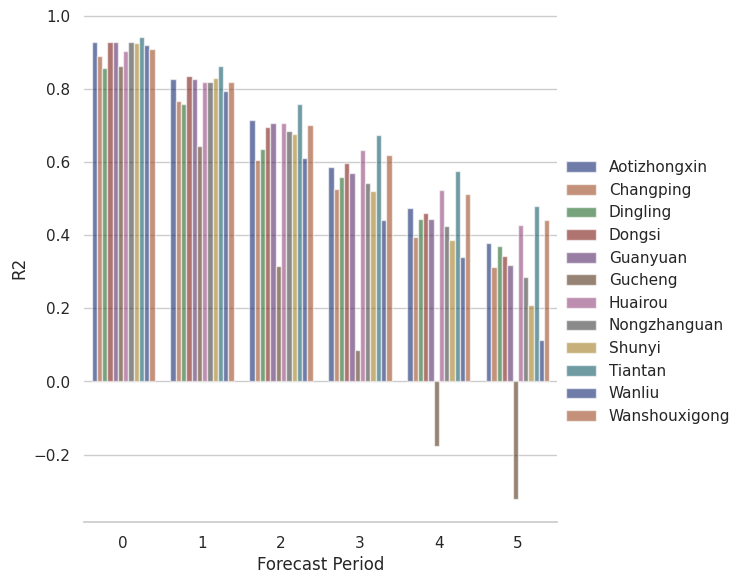

In [43]:
import seaborn as sns
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=df_results, kind="bar",
    x="periods", y="R2", hue="stations",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Forecast Period", "R2")
g.legend.set_title("")

/home/sergio/code/tf/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


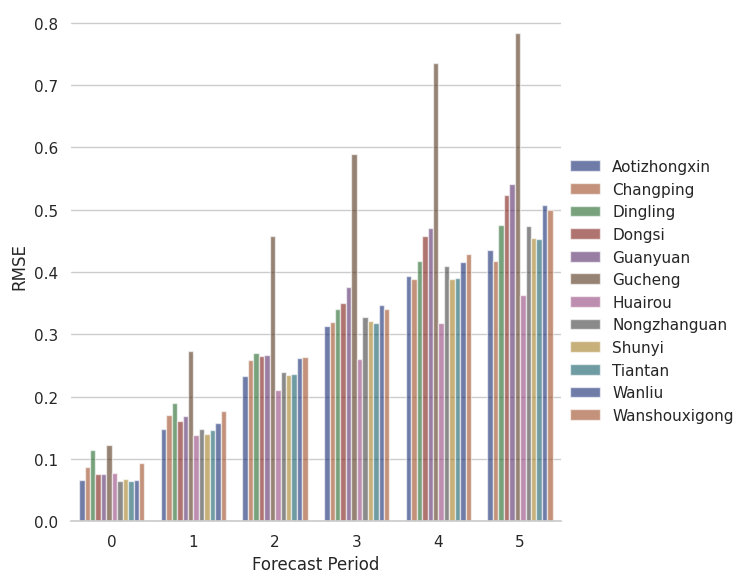

In [44]:
g = sns.catplot(
    data=df_results, kind="bar",
    x="periods", y="RMSE", hue="stations",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Forecast Period", "RMSE")
g.legend.set_title("")

/home/sergio/code/tf/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


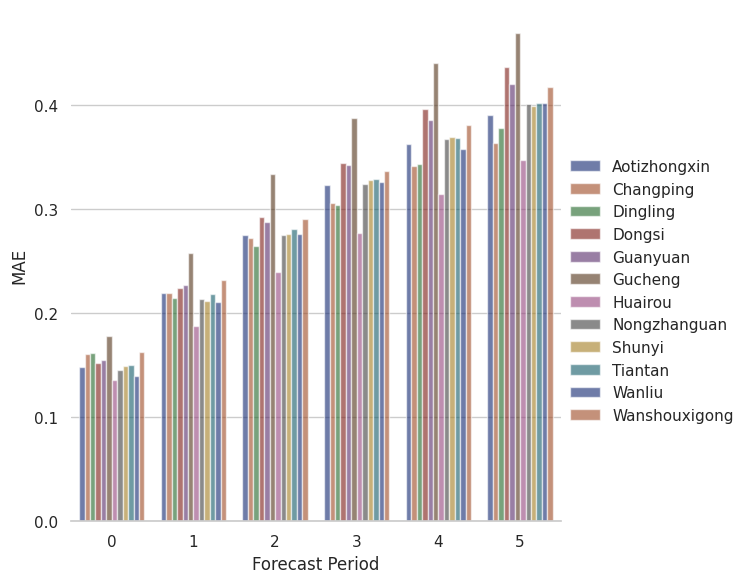

In [45]:
g = sns.catplot(
    data=df_results, kind="bar",
    x="periods", y="MAE", hue="stations",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Forecast Period", "MAE")
g.legend.set_title("")

In [46]:
ensemble_pred=list()
for i in range(len(samples)):
    model_params=reparameterize(samples[i])
    preds=jax.vmap(model.apply, (0, 0))(model_params, X_test)
    ensemble_pred.append(preds)

In [47]:
ensemble_pred=np.stack(ensemble_pred,axis=2)

In [48]:
ensemble_pred.shape

(12, 7002, 100, 6)

In [49]:
mean_pred=np.mean(ensemble_pred,axis=2)
std_pred=np.std(ensemble_pred,axis=2)

In [50]:

r_metric=list()
rmse_metric=list()
mae_metric=list()
stations=list()
periods=list()
for i in range(n_groups):
    for j in range(future):
        r_squared=metrics.r2_score(mean_pred[i,:,j],y_test_datasets[i,:,j])
        rmse=metrics.mean_squared_error(mean_pred[i,:,j],y_test_datasets[i,:,j],squared=True)
        mae=metrics.mean_absolute_error(mean_pred[i,:,j],y_test_datasets[i,:,j])
        periods.append(j)
        stations.append(dataset_names[i])
        #print('forecast period : {4}, task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared,j))
        r_metric.append(r_squared)
        rmse_metric.append(rmse)
        mae_metric.append(mae) 
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

-------------------------------------------------------
RMSE : 0.24, MAE :0.26, R2 :0.67


In [51]:
df_results_ensemble=pd.DataFrame({'stations':stations,
                         'periods':periods,
                         'RMSE':rmse_metric,
                         'MAE':mae_metric,
                         'R2':r_metric})
df_results_ensemble.periods=df_results_ensemble['periods'].astype("category")

/home/sergio/code/tf/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


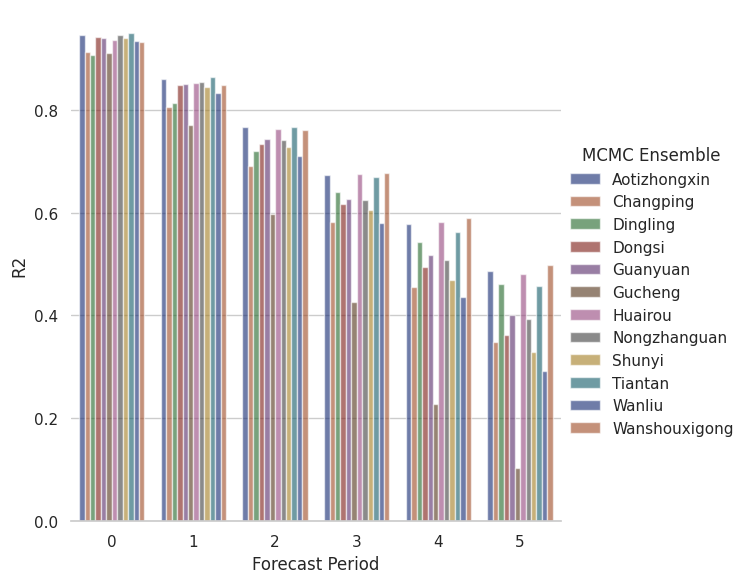

In [52]:
g = sns.catplot(
    data=df_results_ensemble, kind="bar",
    x="periods", y="R2", hue="stations",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Forecast Period", "R2")
g.legend.set_title("MCMC Ensemble")

In [54]:
y_test_datasets[0,:23,1].shape

(23,)

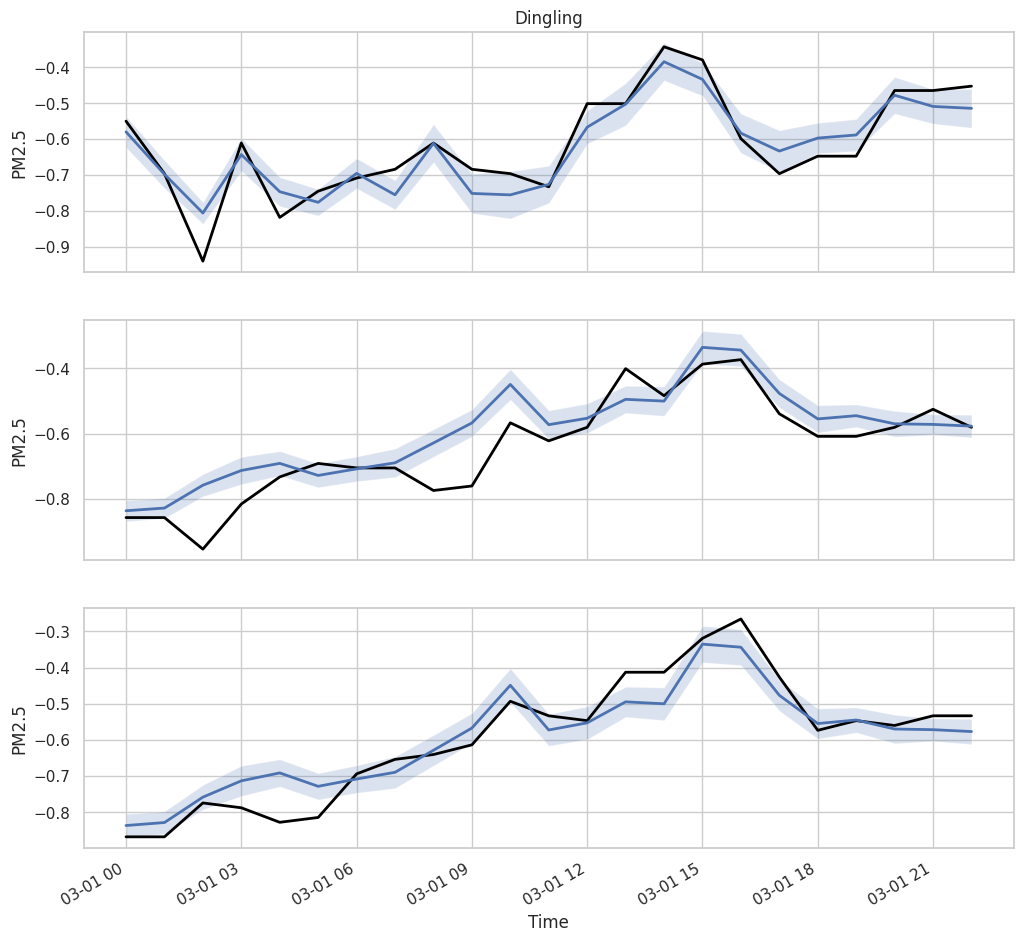

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

future_pred=1
names=np.ravel(gdf.index[0:23].to_frame().values)
ax1.plot(names,y_test_datasets[0,:23,future_pred], linewidth=2,color="black")
ax1.plot(names,mean_pred[0,2:25,future_pred], linewidth=2)
ax1.fill_between(names,np.ravel(mean_pred[0,2:25,future_pred]-std_pred[0,2:25,future_pred]),np.ravel(mean_pred[0,2:25,future_pred]+std_pred[0,2:25,future_pred]),alpha=0.2)
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5')
#ax1.legend(dataset_names[0], loc="upper left", fontsize="xx-large")
ax1.grid(True)

ax2.plot(names,y_test_datasets[1,:23,future_pred], linewidth=2,color="black")
ax2.plot(names,mean_pred[2,2:25,future_pred], linewidth=2)
ax2.fill_between(names,np.ravel(mean_pred[2,2:25,future_pred]-std_pred[2,2:25,future_pred]),np.ravel(mean_pred[2,2:25,future_pred]+std_pred[2,2:25,future_pred]),alpha=0.2)
ax2.set_xlabel('Time')
ax2.set_ylabel('PM2.5')
ax1.set_title(dataset_names[1])
ax2.grid(True)

ax3.plot(names,y_test_datasets[2,:23,future_pred], linewidth=2,color="black")
ax3.plot(names,mean_pred[2,2:25,future_pred], linewidth=2)
ax3.fill_between(names,np.ravel(mean_pred[2,2:25,future_pred]-std_pred[2,2:25,future_pred]),np.ravel(mean_pred[2,2:25,future_pred]+std_pred[2,2:25,future_pred]),alpha=0.2)
ax3.set_xlabel('Time')
ax3.set_ylabel('PM2.5')
ax1.set_title(dataset_names[2])
ax3.grid(True)

fig.autofmt_xdate()

In [56]:
def quantization(x, s, z, alpha_q, beta_q):
    x_q = np.round(1 / s * x + z, decimals=0)
    x_q = np.clip(x_q, a_min=alpha_q, a_max=beta_q)
    return x_q


def quantization_int8(x, s, z):
    x_q = quantization(x, s, z, alpha_q=-128, beta_q=127)
    x_q = x_q.astype(np.int8)
    return x_q

def dequantization(x_q, s, z):
    # x_q - z might go outside the quantization range.
    x_q = x_q.astype(np.int32)
    x = s * (x_q - z)
    x = x.astype(np.float64)
    return x


def generate_quantization_constants(alpha, beta, alpha_q, beta_q):
    # Affine quantization mapping
    s = (beta - alpha) / (beta_q - alpha_q)
    z = int((beta * alpha_q - alpha * beta_q) / (beta - alpha))
    return s, z


def generate_quantization_int8_constants(alpha, beta):
    b = 8
    alpha_q = -2**(b - 1)
    beta_q = 2**(b - 1) - 1
    s, z = generate_quantization_constants(alpha=alpha,
                                           beta=beta,
                                           alpha_q=alpha_q,
                                           beta_q=beta_q)
    return s, z

In [57]:
from stein_thinning.stein import ksd, kmat
from stein_thinning.thinning import thin
from stein_thinning.kernel import make_imq, make_precon

def sgmcmc_diagnostic(samples,X,y):
    logpdf = log_post(params, X, y)
    grads = grad_log_post(params, X, y)
    numpy_grads=np.array(grads)
    ksd_samples=list()
    for i in range(samples.shape[0]):
        vfk0 = make_imq(samples[i,:],numpy_grads[i,:], pre='sclmed')
        ks_smp=ksd(samples[i,:],numpy_grads[i,:],vfk0)
        ksd_samples.append(np.sqrt(np.sum(ks_smp))/len(ks_smp))
    log_ksd = np.log10(ksd_samples)
    return log_ksd

def quantize_samples(samples):
    s=list()
    z=list()
    q_samples=np.zeros_like(samples).astype(np.int8)
    for i in range(samples.shape[0]):
        alpha=np.min(samples[i,:])
        beta=np.max(samples[i,:])
        ss,zz=generate_quantization_int8_constants(alpha,beta)
        x_q=quantization_int8(samples[i,:],ss,zz)
        q_samples[i,:]=x_q
        s.append(ss)
        z.append(zz)
    return q_samples,s,z

def dequantizate_samples(q_samples,s,z):
    samples=np.zeros_like(q_samples).astype(np.float16)
    for i in range(q_samples.shape[0]):
        samples[i,:]=dequantization(q_samples[i,:], s[i], z[i])
    return samples

#ksd_float64=sgmcmc_diagnostic(samples,mu,sigma)
#ksd_float16=sgmcmc_diagnostic(samples.astype(np.float16),mu,sigma)

#q_samples,s,z=quantize_samples(samples)
#r_samples=dequantizate_samples(q_samples,s,z)
#ksd_int8=sgmcmc_diagnostic(r_samples,mu,sigma)

In [62]:
from typing import (
    List,
    Optional,
)

from jax import (
    jit,
    lax,
    vmap,
)
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
from optax._src.base import PyTree


@jit
def kernel_stein_discrepancy_imq(
    samples: List[PyTree],
    grads: List[PyTree],
    c: float = 1.0,
    beta: float = -0.5,
) -> float:
    """Kernel Stein Discrepancy with the Inverse Multiquadric (IMQ) kernel.

    See `Gorham J. and Mackey L., 2017 <https://proceedings.mlr.press/v70/gorham17a/gorham17a.pdf>`_ for more details.

    Parameters
    ----------
        samples: List[PyTree]
            The list of `PyTree`, each representing an MCMC sample.
        grads: List[PyTree]
            The list of the corresponding density gradients.
        c: float
            :math:`c > 0` kernel bias hyperparameter.
        beta: float
            :math:`beta < 0` kernel exponent hyperparameter.

    Returns
    -------
        ksd_img: float
            The kernel Stein discrepancy value.
    """
    if not c > 0:
        raise ValueError("`c` should be > 0.")
    if not beta < 0:
        raise ValueError("`beta` should be < 0.")

    samples = ravel_pytree(samples)[0].reshape(len(samples), -1)
    grads = ravel_pytree(grads)[0].reshape(len(grads), -1)

    def _k_0(param1, param2, grad1, grad2, c, beta):
        dim = param1.shape[0]
        diff = param1 - param2
        base = c**2 + jnp.dot(diff, diff)
        kern = jnp.dot(grad1, grad2) * base**beta
        kern += -2 * beta * jnp.dot(grad1, diff) * base ** (beta - 1)
        kern += 2 * beta * jnp.dot(grad2, diff) * base ** (beta - 1)
        kern += -2 * dim * beta * (base ** (beta - 1))
        kern += -4 * beta * (beta - 1) * base ** (beta - 2) * jnp.sum(jnp.square(diff))
        return kern

    _batched_k_0 = vmap(_k_0, in_axes=(None, 0, None, 0, None, None))

    def _ksd(accum, x):
        sample1, grad1 = x
        accum += jnp.sum(_batched_k_0(sample1, samples, grad1, grads, c, beta))
        return accum, None

    ksd_sum, _ = lax.scan(_ksd, 0.0, (samples, grads))
    return jnp.sqrt(ksd_sum) / samples.shape[0]


def effective_sample_size(
    samples: List[PyTree], filter_threshold: Optional[float] = 0.0
) -> PyTree:
    """Estimate the effective sample size of a sequence.

    For a sequence of length :math:`N`, the effective sample size is defined as

    :math:`ESS(N) =  N / [ 1 + 2 * ( (N - 1) / N * R_1 + ... + 1 / N * R_{N-1} ) ]`

    where :math:`R_k` is the auto-correlation sequence,
    :math:`R_k := Cov{X_1, X_{1+k}} / Var{X_1}`

    Parameters
    ----------
        samples: List[PyTree]
            The list of `PyTree`, each representing an MCMC sample.
        filter_threshold: Optional[float]
            The cut-off value to truncate the sequence at the first index where
            the estimated auto-correlation is less than the threshold.

    Returns
    -------
        ESS: PyTree
            Parameter-wise estimates of the effective sample size.

    """
    unravel_fn = ravel_pytree(samples[0])[1]
    samples = ravel_pytree(samples)[0].reshape(len(samples), -1)

    def _autocorr(x, axis=-1, center=True):
        """Compute auto-correlation along one axis."""

        dtype = x.dtype
        shift = (-1 - axis) if axis < 0 else (len(x.shape) - 1 - axis)
        x = jnp.transpose(x, jnp.roll(jnp.arange(len(x.shape)), shift))
        if center:
            x -= x.mean(axis=-1, keepdims=True)

        # Zero pad to the next power of 2 greater than 2 * x_len
        x_len = x.shape[-1]
        pad_len = int(2.0 ** jnp.ceil(jnp.log2(x_len * 2)) - x_len)
        x = jnp.pad(x, (0, pad_len))[:-pad_len]

        # Autocorrelation is IFFT of power-spectral density
        fft = jnp.fft.fft(x.astype(jnp.complex64))
        prod = jnp.fft.ifft(fft * jnp.conj(fft))
        prod = jnp.real(prod[..., :x_len]).astype(dtype)

        # Divide to obtain an unbiased estimate of the expectation
        denominator = x_len - jnp.arange(0.0, x_len)
        res = prod / denominator
        return jnp.transpose(res, jnp.roll(jnp.arange(len(res.shape)), -shift))

    auto_cov = _autocorr(samples, axis=0)
    auto_corr = auto_cov / auto_cov[:1]

    n = len(samples)
    nk_factor = (n - jnp.arange(0.0, n)) / n
    weighted_auto_corr = nk_factor[..., None] * auto_corr

    if filter_threshold is not None:
        mask = (auto_corr < filter_threshold).astype(auto_corr.dtype)
        mask = jnp.cumsum(mask, axis=0)
        mask = jnp.maximum(1.0 - mask, 0.0)
        weighted_auto_corr *= mask

    ess = n / (-1 + 2 * weighted_auto_corr.sum(axis=0))
    return unravel_fn(ess)

In [82]:
ensemble_grads=list()
ensemble_params=list()
for i in range(len(samples)):
    model_params=reparameterize(samples[i])
    grads = grad_log_post(samples[i], X_test, y_test)
    ensemble_grads.append(grads)
    ensemble_params.append(model_params)

(100, 82460)

In [83]:
ksd=kernel_stein_discrepancy_imq(samples,ensemble_grads)

2024-01-02 13:11:41.481237: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_kernel_stein_discrepancy_imq] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-01-02 13:12:35.574471: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m54.093312837s

********************************
[Compiling module jit_kernel_stein_discrepancy_imq] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [97]:
def quantized_reparameterize(params,dtype=jnp.float32):
    mu = jax.tree_map(lambda p : p.astype(dtype),params['mu'])
    sigma = jax.tree_map(lambda p : jnp.exp(0.5*p).astype(dtype),params['log_std'])
    eps = jax.tree_map(lambda p : p.astype(dtype),params['eps'])
    #eps=jax.tree_map(lambda p: jax.random.normal(key=jax.random.PRNGKey(np.random.randint(42)),shape=p.shape), params['eps'])
    model_params = jax.tree_map(lambda m,e,s : m+e*s,mu,eps,sigma)
    return model_params

def quantized_grads(grads,dtype=jnp.float32):
    mu = jax.tree_map(lambda p : p.astype(dtype),grads['mu'])
    sigma = jax.tree_map(lambda p : p.astype(dtype),grads['log_std'])
    eps = jax.tree_map(lambda p : p.astype(dtype),grads['eps'])
    q_grads={'mu':mu,'sigma':sigma,'eps':eps}
    return q_grads

In [101]:
ensemble_grads=list()
ensemble_params=list()
for i in range(len(samples)):
    model_params=quantized_reparameterize(samples[i],jnp.float16)
    grads = grad_log_post(samples[i], X_test, y_test)
    q_grads=quantized_reparameterize(grads,jnp.float16)
    ensemble_grads.append(q_grads)
    ensemble_params.append(model_params)

In [107]:
grads.keys()

dict_keys(['eps', 'log_std', 'mu'])